<a href="https://colab.research.google.com/github/ThisIsFarhan/AgenticRag-LangGraph/blob/main/Agentic_Rag.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [81]:
%%capture --no-stderr
%pip install --quiet -U langchain langchain_community pypdf tiktoken langchain_groq langgraph tavily-python sentence_transformers langchain_huggingface

In [116]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import PyPDFLoader
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_community.vectorstores import SKLearnVectorStore
from langchain_community.tools.tavily_search import TavilySearchResults
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display
from typing_extensions import TypedDict
from typing import List
from langchain_groq import ChatGroq
from langchain.schema import Document
import os

In [113]:
from google.colab import userdata

groq_api_key=userdata.get('groq_api_key')
tavily_key = userdata.get('TAVILY_API_KEY')
os.environ['TAVILY_API_KEY'] = tavily_key
llm=ChatGroq(groq_api_key=groq_api_key,model_name="Gemma2-9b-It")

In [84]:
embeddings = HuggingFaceEmbeddings(model_name="all-mpnet-base-v2")

In [85]:
loader = PyPDFLoader(
    file_path = "./iot_pdf.pdf",
)
documents = loader.load()

In [86]:
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=1000, chunk_overlap=200
)
doc_splits = text_splitter.split_documents(documents)

In [87]:
vectorstore = SKLearnVectorStore.from_documents(
    documents=doc_splits,
    embedding=embeddings,
)

In [88]:
retriever = vectorstore.as_retriever(k=3)

In [97]:
retriever.invoke("ipv6")

[Document(metadata={'id': '7607af94-32c5-4127-b93a-67a97dceefd7', 'source': './iot_pdf.pdf', 'page': 2, 'page_label': '3'}, page_content='8\n2.1 IPv6 Introduction  \nWhen we use the Internet for any activ ity, be it e-mail, data transmission, web \nbrowsing, downloading files, images or videos or any other service or application, \ncommunication between different network elements and our own computer, laptop \nor smart phone, uses a protocol: The IP (Internet protocol) which specifies the \ntechnical format of packets and the addressing scheme for computers to \ncommunicate over a network. \n \nIPv6 (Internet protocol version 6 ) is the most recent version of the IP, the \ncommunications protocol that provides an  identification and location system for \ncomputers on networks and routes traffic across the Internet. \n \nIn order to connect any device to Internet it’s necessary to provide an IP address to \nthe device. The first version of an Internet Protocol publicly used was IPv4 (In

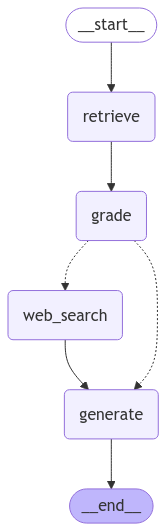

In [119]:

class State(TypedDict):
  question:str #question asked by the user
  retrieved_docs:List[str] #docs retrieved from the database
  web_search_decision:str # Yes or No (whether or not the documents are related to each other)
  generated_response:str

#Nodes Definition
def retrieve(state:State):
  print("------Retrieve------")
  ques = state["question"]
  documents = retriever.invoke(ques)
  return {"retrieved_docs":documents}




doc_grader_instructions = """You are a grader assessing relevance of a retrieved document to a user question.

If the document contains keyword(s) or semantic meaning related to the question, grade it as relevant."""

doc_grader_prompt = """Here is the retrieved document: \n\n {document} \n\n Here is the user question: \n\n {question}.

This carefully and objectively assess whether the document contains at least some information that is relevant to the question.

Return binary_score, that is only 'yes' or 'no' to indicate whether the document contains at least some information that is relevant to the question."""

def grade(state:State):
  print("------Grade------")
  docs = state["retrieved_docs"]
  ques = state["question"]
  web_search = "no"
  filtered = []
  for d in docs:
    doc_grader_prompt_formatted = doc_grader_prompt.format(document=d.page_content, question=ques)
    result = llm.invoke(
                    [SystemMessage(content=doc_grader_instructions)]
                    + [HumanMessage(content=doc_grader_prompt_formatted)]
                  )
    if "yes" in result.content.lower():
      print("---GRADE: DOCUMENT RELEVANT---")
      filtered.append(d)
    else:
      print("---GRADE: DOCUMENT NOT RELEVANT---")
      web_search = "yes"
      continue

  return {"retrieved_docs":filtered,
          "web_search_decision":web_search
          }


def web_search(state:State):
    print("---WEB SEARCH---")
    ques = state["question"]
    documents = state["retrieved_docs"]

    # Web search
    web_search_tool = TavilySearchResults(max_results=3)
    docs = web_search_tool.invoke({"query": ques})
    web_results = "\n".join([d["content"] for d in docs])
    web_results = Document(page_content=web_results)
    documents.append(web_results)
    return {"retrieved_docs": documents}




rag_prompt = """You are an assistant for question-answering tasks.

Here is the context to use to answer the question:

{context}

Think carefully about the above context.

Now, review the user question:

{question}

Provide an answer to this questions using only the above context. If the context contains any URLs, then you should mention the URLs in the answer and mention that the answers have been fetched from web search since the provided pdf did not contain that information

keep the answer concise.

Answer:"""

def generate(state:State):
    print("------Generate------")
    docs = state["retrieved_docs"]
    ques = state["question"]

    docs_txt = "\n\n".join(doc.page_content for doc in docs)
    rag_prompt_formatted = rag_prompt.format(context=docs_txt, question=ques)
    generation = llm.invoke([HumanMessage(content=rag_prompt_formatted)])

    return {"generated_response":generation.content}


#conditional edge function
def decide_web_search(state:State):
  print("------Decide Web Search------")
  decision = state["web_search_decision"]
  if decision == "yes":
    return "web_search"
  else:
    return "generate"

#Graph Building
builder = StateGraph(State)
builder.add_node("retrieve",retrieve)
builder.add_node("grade",grade)
builder.add_node("web_search",web_search)
builder.add_node("generate",generate)

builder.add_edge(START,"retrieve")
builder.add_edge("retrieve","grade")
builder.add_conditional_edges("grade",decide_web_search,["web_search","generate"])
builder.add_edge("web_search","generate")
builder.add_edge("generate",END)

graph = builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

In [126]:
inputs = {"question": "Smart connected products capabilities"}
responses = {}  # Store responses for each node

for event in graph.stream(inputs, stream_mode="values"):
    responses.update(event)  # Store response

print("\nGenerated Response:")
print(responses['generated_response'])  # Access generated response

------Retrieve------
------Grade------
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
------Decide Web Search------
---WEB SEARCH---
------Generate------

Generated Response:
Smart connected products capabilities can be grouped into four areas: 

1. **Monitoring:**  Tracking the product's condition, operations, and usage.
2. **Control:** Allowing users to control product functions, personalize experiences, and program settings.
3. **Optimization:**  Using predictive diagnostics, performance optimization, and cost reduction strategies.
4. **Autonomy:** Enabling self-diagnosis, repair, coordination with other products, and efficient decision-making through real-time data. 



